In [1]:
import numpy as np
import scienceplots
from matplotlib import pyplot as plt
import pandas as pd
import os
import scipy as sp
import seaborn as sns
import json
import yaml
import functools
import itertools

In [125]:
prefix='cryptonce-2'

In [126]:
def average_data(df, keep=['cpu', 'client']):
    res = df.groupby(keep+['run']).mean(numeric_only=True).reset_index()
    res = res.groupby(keep).mean(numeric_only=True).reset_index()
    return res

def sum_data(df, keep=['cpu', 'client']):
    res = df.groupby(keep+['run']).sum(numeric_only=True).reset_index()
    res = res.groupby(keep).mean(numeric_only=True).reset_index()
    return res

def import_throughput(res_dir):
    throughput_csv = pd.read_csv(f"../{res_dir}/summary/server/throughput-sar.csv")
    
#     throughput_csv['client'] *= 10
    throughput_csv['rxkB/s'] *= 8e-6
    throughput_csv['txkB/s'] *= 8e-6
    throughput_csv['rxpck/s'] *= 1e-6
    throughput_csv['txpck/s'] *= 1e-6
    throughput_csv['expected'] = throughput_csv['client'] * 1

    throughput_wg = throughput_csv[throughput_csv.iface == 'wg']
    throughput_phy = throughput_csv[throughput_csv.iface == 'eno1']    

    net_wg = average_data(throughput_wg)
    net_phy = average_data(throughput_phy)
    
    return net_wg, net_phy

def import_cpu(res_dir):
    cpu_csv = pd.read_csv(f"../{res_dir}/summary/server/cpu-sar.csv")
    
#     cpu_csv['client'] *= 10
    cpu_csv['used'] = 100 - cpu_csv['idle']

    cpu = average_data(cpu_csv, keep=['cpu', 'client', 'core'])
    
    per_core = cpu[cpu.core != -1]
    global_cpu = cpu[cpu.core == -1]
    
    return global_cpu, per_core

def import_iperf(res_dir):
    df_t = []
    for i in range(1, 2):
        try:
            net_client_csv = pd.read_csv(
                f"../{res_dir}/summary/clients/throughput-{i}.csv",
            )
            net_df = average_data(net_client_csv, keep=['cpu', 'client', 'node'])
            net_df_sum = net_df.groupby(['cpu', 'client']).sum().reset_index()
            net_df_avg = net_df.groupby(['cpu', 'client']).mean().reset_index()
            net_df_sum['throughput'] *= 1e-3
            net_df_sum['node'] = i
            df_t.append(net_df_sum)
        except:
            continue
    df = pd.concat(df_t, axis=0)
    
    df = df.groupby(['cpu', 'client']).sum().reset_index()
    
    return df

def import_latency(res_dir):
    df_t = []
    for i in range(1, 11):
        try:
            latency_csv = pd.read_csv(
                f"../{res_dir}/summary/clients/latency-{i}.csv",
                names=['cpu', 'client', 'node', 'run', 'min', 'mean', 'median', '90th', '99th', 'max', 'std'],
                skiprows=1
            )
        except:
            continue
        latency_df = average_data(latency_csv, keep=['cpu', 'client'])
#         latency_df['client'] *= 10
        latency_df[['mean', 'median', '90th', '99th', 'max', 'std']] *= 1e-3
        latency_df['node'] = i
        df_t.append(latency_df)
    df = pd.concat(df_t, axis=0)
    
    latency_df = df.groupby(['cpu', 'client']).mean().reset_index()
    
    return latency_df

In [127]:
def reslv_res_name(res_dir):
    filename = f"../{res_dir}/EXPERIMENT_DATA/TEST_CONFIG"    
    with open(filename) as file:
        test_config = file.read().strip()
    
    yaml_file = f"../{res_dir}/EXPERIMENT_DATA/{test_config}.yaml"
    with open(yaml_file) as file:
        content = yaml.load(file, yaml.FullLoader)
        flow = content['all']['vars']['bandwidth']
    
    if test_config != 'default':
        use_case, crypted, traffic = test_config.split('--')
        crypted = crypted.split('-')[0]
    else:
        use_case = wg_variant = traffic = flow = None
        
    return test_config, use_case, flow, crypted, traffic

In [185]:
def describe_test(test, throuhgput='rxkB/s', ylim_cpu=[-1, 30], ylim_net=[-0.2, 5], client=100):
    res_dir = test[0]
    print(test[1])
    global_cpu, per_core_cpu = import_cpu(res_dir)
    df = per_core_cpu.groupby('client').sum(numeric_only=True).reset_index()
    print(df[['client', 'used']])

    cpu_csv = pd.read_csv(f"../{res_dir}/summary/server/cpu-sar.csv")
    cpu_csv['used'] = 100 - cpu_csv['idle']
    cpu_csv = cpu_csv[cpu_csv.core == -1].reset_index(drop=True)
    
    cpu_csv_1 = cpu_csv[cpu_csv.client == 1].reset_index(drop=True).reset_index()

    ax = cpu_csv_1.plot(x='index', y='used', grid=True, ylabel='CPU usage', ylim=ylim_cpu, xlabel='Time in S', label=test[1])

    latency = import_latency(res_dir)
    print(latency[['client', 'mean', 'median', '90th', '99th']])
    
    res_dir = test[0]
    print(test[1])
    net_wg, net_phy = import_throughput(res_dir)
    print(net_wg[['client', throuhgput]])

    throughput_csv = pd.read_csv(f"../{res_dir}/summary/server/throughput-sar.csv")

    throughput_csv['rxkB/s'] *= 8e-6
    throughput_csv['txkB/s'] *= 8e-6
    throughput_csv['rxpck/s'] *= 1e-6
    throughput_csv['txpck/s'] *= 1e-6
    throughput_csv['expected'] = throughput_csv['client'] * 1

    throughput_wg = throughput_csv[throughput_csv.iface == 'wg']
    throughput_phy = throughput_csv[throughput_csv.iface == 'eno1'] 

    throughput_wg_1 = throughput_wg[throughput_wg.client == client].reset_index(drop=True).reset_index()

    ax = throughput_wg_1.plot(x='index', y=throuhgput, grid=True, ylabel='Throuhgput (in Gbps)', ylim=ylim_net, xlabel='Time in S', label=test[1])

In [186]:
res_dirs = [(f"{prefix}/{e}", *reslv_res_name(f"{prefix}/{e}")) 
            for e in os.listdir(f"../{prefix}") if e.startswith("results-")]

In [187]:
filter_index = []

In [188]:
list(enumerate(res_dirs))

[(0,
  ('cryptonce-2/results-604f2387',
   'upload--partial-go--tcp',
   'upload',
   '25000M',
   'partial',
   'tcp')),
 (1,
  ('cryptonce-2/results-b14233eb',
   'upload--yes-go--tcp',
   'upload',
   '25000M',
   'yes',
   'tcp')),
 (2,
  ('cryptonce-2/results-1c601640',
   'upload--partial-go--tcp',
   'upload',
   '25000M',
   'partial',
   'tcp')),
 (3,
  ('cryptonce-2/results-85269bc6',
   'upload--no-go--tcp',
   'upload',
   '25G',
   'no',
   'tcp')),
 (4,
  ('cryptonce-2/results-c4c2a4db',
   'download--partial-go--tcp',
   'download',
   '25G',
   'partial',
   'tcp')),
 (5,
  ('cryptonce-2/results-354679d7',
   'upload--yes-go--tcp',
   'upload',
   '25000M',
   'yes',
   'tcp')),
 (6,
  ('cryptonce-2/results-df203855',
   'download--yes-go--tcp',
   'download',
   '25G',
   'yes',
   'tcp')),
 (7,
  ('cryptonce-2/results-c1f8f489',
   'download--no-go--tcp',
   'download',
   '25G',
   'no',
   'tcp'))]

In [189]:
import_latency(res_dirs[6][0])

,cpu,client,run,node,min,mean,median,90th,99th,max,std
0,18,1,2.0,1.0,119.000000,0.176400,0.150000,0.190000,0.190000,0.445000,0.092303
1,18,50,2.0,1.0,110.820000,0.161783,0.151760,0.194213,0.194213,0.277293,0.045923
2,18,100,2.0,1.0,107.036667,0.152227,0.142137,0.185820,0.185820,0.252950,0.041031


In [190]:
import_latency(res_dirs[4][0])

,cpu,client,run,node,min,mean,median,90th,99th,max,std
0,18,1,2.0,1.0,104.333333,0.171267,0.139333,0.180000,0.180000,0.479667,0.105183
1,18,50,2.0,1.0,104.120000,0.149569,0.139527,0.180820,0.180820,0.253560,0.041492
2,18,100,2.0,1.0,102.000000,0.146694,0.137223,0.176047,0.176047,0.246913,0.040307


In [191]:
import_latency(res_dirs[7][0])

,cpu,client,run,node,min,mean,median,90th,99th,max,std
0,18,1,2.0,1.0,105.000000,0.156567,0.13400,0.170000,0.170000,0.388333,0.078953
1,18,50,2.0,1.0,110.046667,0.158591,0.14680,0.190093,0.190093,0.277813,0.046487
2,18,100,2.0,1.0,109.643333,0.155437,0.14627,0.188707,0.188707,0.252480,0.040009


download--yes-go--tcp
   client        used
0       1  303.381833
1      50  450.058500
2     100  537.876167
   client      mean    median      90th      99th
0       1  0.176400  0.150000  0.190000  0.190000
1      50  0.161783  0.151760  0.194213  0.194213
2     100  0.152227  0.142137  0.185820  0.185820
download--yes-go--tcp
   client    txkB/s
0       1  6.145655
1      50  5.310168
2     100  4.419210


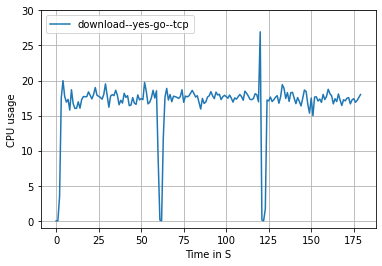

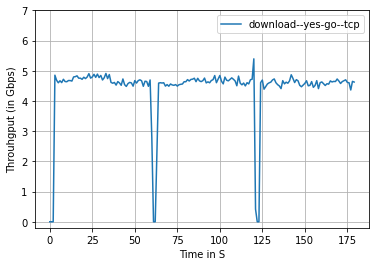

In [192]:
describe_test(res_dirs[6], throuhgput='txkB/s', ylim_net=[-.2, 7])

download--partial-go--tcp
   client        used
0       1  301.358333
1      50  446.414889
2     100  525.172944
   client      mean    median      90th      99th
0       1  0.171267  0.139333  0.180000  0.180000
1      50  0.149569  0.139527  0.180820  0.180820
2     100  0.146694  0.137223  0.176047  0.176047
download--partial-go--tcp
   client    txkB/s
0       1  6.152239
1      50  5.160972
2     100  4.472530


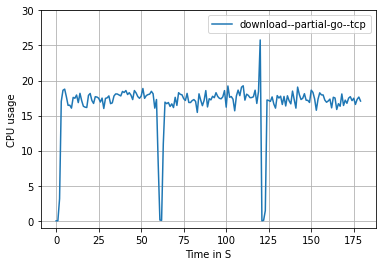

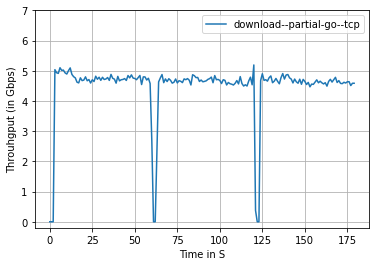

In [193]:
describe_test(res_dirs[4], throuhgput='txkB/s', ylim_net=[-.2, 7])

download--no-go--tcp
   client        used
0       1  305.796389
1      50  442.973556
2     100  539.354611
   client      mean   median      90th      99th
0       1  0.156567  0.13400  0.170000  0.170000
1      50  0.158591  0.14680  0.190093  0.190093
2     100  0.155437  0.14627  0.188707  0.188707
download--no-go--tcp
   client    txkB/s
0       1  6.141799
1      50  5.126823
2     100  4.390526


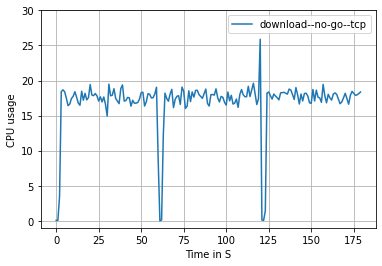

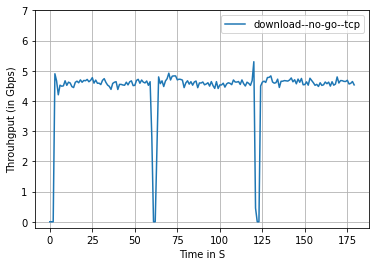

In [194]:
describe_test(res_dirs[7], throuhgput='txkB/s', ylim_net=[-.2, 7])